# Basics of lattice models
In this notebook, we'll explain a lattice model, an interpolated lookup table.
In addition, we'll show how monotonicity and smooth regularizers can change the model.

First we need to import libraries we're going to use.

In [1]:
import tensorflow as tf
import tensorflow_lattice as tfl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

# Lattice model visualization

Now, let us define helper functions for visualizing the surface of 2d lattice.

In [67]:
# Hypercube (multilinear) interpolation in a 2 x 2 lattice.
# params[0] == lookup value at (0, 0)
# params[1] == lookup value at (0, 1)
# params[2] == lookup value at (1, 0)
# params[3] == lookup value at (1, 1)
def twod(x1, x2, params):
    y = ((1 - x1) * (1 - x2) * params[0]
         + (1 - x1) * x2 * params[1]
         + x1 * (1 - x2) * params[2]
         + x1 * x2 * params[3])
    return y

# This function will generate 3d plot for lattice function values.
# params uniquely characterizes the lattice lookup values.
def lattice_surface(params, rotation=160):
    print('Lattice params:')
    print(params)
    
    %matplotlib inline
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    # Make data.
    n = 50
    xv, yv = np.meshgrid(np.linspace(0.0, 1.0, num=n),
                         np.linspace(0.0, 1.0, num=n))
    zv = np.zeros([n, n])
    for k1 in range(n):
        for k2 in range(n):
            zv[k1, k2] = twod(xv[k1, k2], yv[k1, k2], params)

    # Plot the surface.
    surf = ax.plot_surface(xv, yv, zv, cmap=cm.coolwarm)
    # Customize the z axis.
    ax.set_zlim(0.0, 1.0)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    ax.view_init(30, rotation)

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5,)

Let's draw a surface of 2d lattice model.
This model represents an "XOR" function.

Lattice params:
[0.0, 1.0, 1.0, 0.0]


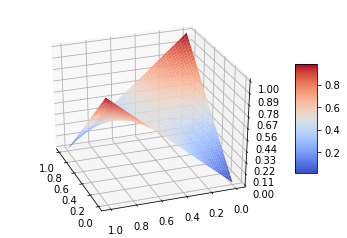

In [68]:
# This will plot the surface plot.
lattice_surface([0.0, 1.0, 1.0, 0.0])

Lattice params:
[1.0, 1.0, 1.0, 1.0]


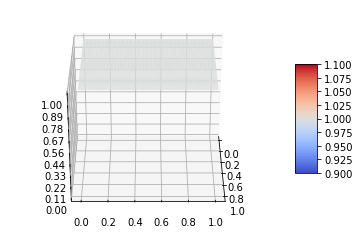

In [73]:
lattice_surface([1.0, 1.0, 1.0, 1.0],rotation=0)

# Train XOR function

We'll provide a synthetic data that represents the "XOR" function, that is

f(0, 0) = 0
f(0, 1) = 1
f(1, 0) = 1
f(1, 1) = 0

and check whether a lattice can __learn__ this function.

Lattice params:
[0.        0.9999994 0.9999994 0.9999994]


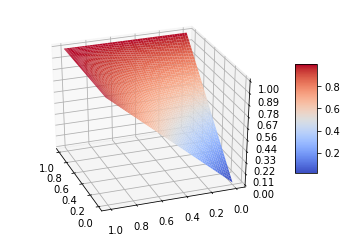

In [61]:
# Reset the graph.
tf.reset_default_graph()

# Prepare the dataset.
x_data = [[0.0, 0.0], [0.0, 1.0], [1.0, 0.0], [1.0, 1.0]]
# y_data = [[0.0], [1.0], [1.0], [0.0]] # XOR 
y_data = [[0.0], [1.0], [1.0], [1.0]] # AND 

# Define placeholders.
x = tf.placeholder(dtype=tf.float32, shape=(None, 2))
y_ = tf.placeholder(dtype=tf.float32, shape=(None, 1))

# 2 x 2 lattice with 1 output.
# lattice_param is [output_dim, 4] tensor.
lattice_sizes = [2, 2]
(y, lattice_param, _, _) = tfl.lattice_layer(
    x, lattice_sizes=[2, 2], output_dim=1)

# Sqaured loss
loss = tf.reduce_mean(tf.square(y - y_))

# Minimize!
train_op = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
# Iterate 100 times
for _ in range(1000):
    sess.run(train_op, feed_dict={x: x_data, y_: y_data})

# Fetching trained lattice parameter.
lattice_param_val = sess.run(lattice_param)
# Draw the surface!
lattice_surface(lattice_param_val[0])

# Train with monotonicity
Now we'll set monotonicity in a lattice model. We'll use the same synthetic data generated by "XOR" function, but now we'll require full monotonicity in both directions, x1 and x2. Note that the data does not contain monotonicity, since "XOR" function value decreases, i.e., f(1, 0) > f(1, 1) and f(0, 1) > f(1, 1).
So the trained model will do its best to fit the data while satisfying the monotonicity.

Lattice params:
[-0.00296026  0.6637064   0.6637064   0.6637064 ]


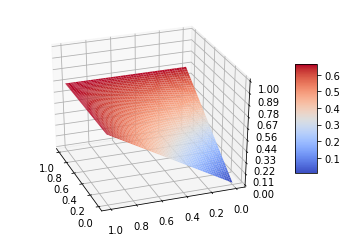

In [62]:
tf.reset_default_graph()

x_data = [[0.0, 0.0], [0.0, 1.0], [1.0, 0.0], [1.0, 1.0]]
y_data = [[0.0], [1.0], [1.0], [0.0]]

x = tf.placeholder(dtype=tf.float32, shape=(None, 2))
y_ = tf.placeholder(dtype=tf.float32, shape=(None, 1))

# 2 x 2 lattice with 1 output.
# lattice_param is [output_dim, 4] tensor.
lattice_sizes = [2, 2]
(y, lattice_param, projection_op, _) = tfl.lattice_layer(
    x, lattice_sizes=[2, 2], output_dim=1, is_monotone=True)

# Sqaured loss
loss = tf.reduce_mean(tf.square(y - y_))

# Minimize!
train_op = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
# Iterate 100 times
for _ in range(100):
    # Apply gradient.
    sess.run(train_op, feed_dict={x: x_data, y_: y_data})
    # Then projection.
    sess.run(projection_op)

# Fetching trained lattice parameter.
lattice_param_val = sess.run(lattice_param)
# Draw it!
# You can see that the prediction does not decrease.
lattice_surface(lattice_param_val[0])

# Train with partial monotonicity
Now we'll set partial monotonicity. Here only one input is constrained to be monotonic.

Lattice params:
[-0.00148013  0.9955596   0.49703982  0.49703982]


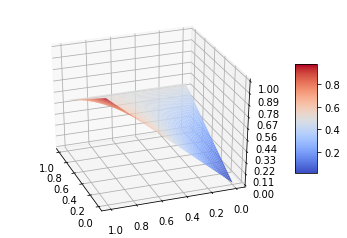

In [63]:
tf.reset_default_graph()

x_data = [[0.0, 0.0], [0.0, 1.0], [1.0, 0.0], [1.0, 1.0]]
y_data = [[0.0], [1.0], [1.0], [0.0]]

x = tf.placeholder(dtype=tf.float32, shape=(None, 2))
y_ = tf.placeholder(dtype=tf.float32, shape=(None, 1))

# 2 x 2 lattice with 1 output.
# lattice_param is [output_dim, 4] tensor.
lattice_sizes = [2, 2]
(y, lattice_param, projection_op, _) = tfl.lattice_layer(
    x, lattice_sizes=[2, 2], output_dim=1, is_monotone=[True, False])

# Sqaured loss
loss = tf.reduce_mean(tf.square(y - y_))

# Minimize!
train_op = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(loss)

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
# Iterate 100 times
for _ in range(100):
    # Apply gradient.
    sess.run(train_op, feed_dict={x: x_data, y_: y_data})
    # Then projection.
    sess.run(projection_op)

# Fetching trained lattice parameter.
lattice_param_val = sess.run(lattice_param)
# Draw it!
# You can see that the prediction does not decrease in one direction.
lattice_surface(lattice_param_val[0])

# Training OR function
Now we switch to a synthetic dataset generated by "OR" function to illustrate other regularizers.
f(0, 0) = 0
f(0, 1) = 1
f(1, 0) = 1
f(1, 1) = 1

Lattice params:
[0.        0.9940795 0.9940795 0.9940795]


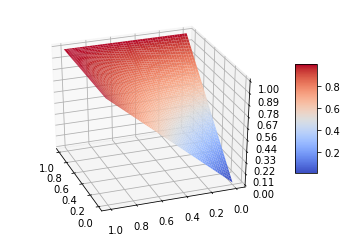

In [64]:
tf.reset_default_graph()

x_data = [[0.0, 0.0], [0.0, 1.0], [1.0, 0.0], [1.0, 1.0]]
y_data = [[0.0], [1.0], [1.0], [1.0]]

x = tf.placeholder(dtype=tf.float32, shape=(None, 2))
y_ = tf.placeholder(dtype=tf.float32, shape=(None, 1))

# 2 x 2 lattice with 1 output.
# lattice_param is [output_dim, 4] tensor.
lattice_sizes = [2, 2]
(y, lattice_param, _, _) = tfl.lattice_layer(
    x, lattice_sizes=[2, 2], output_dim=1)

# Sqaured loss
loss = tf.reduce_mean(tf.square(y - y_))

# Minimize!
train_op = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(loss)

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
# Iterate 100 times
for _ in range(100):
    # Apply gradient.
    sess.run(train_op, feed_dict={x: x_data, y_: y_data})

# Fetching trained lattice parameter.
lattice_param_val = sess.run(lattice_param)
# Draw it!
lattice_surface(lattice_param_val[0])

# Laplacian regularizer
Laplacian regularizer puts the penalty on lookup value changes. In other words, it tries to make the slope of each face as small as possible.

Lattice params:
[0.44444403 0.5555551  0.9999994  0.9999994 ]


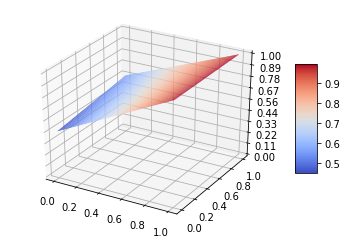

In [15]:
tf.reset_default_graph()

x_data = [[0.0, 0.0], [0.0, 1.0], [1.0, 0.0], [1.0, 1.0]]
y_data = [[0.0], [1.0], [1.0], [1.0]]

x = tf.placeholder(dtype=tf.float32, shape=(None, 2))
y_ = tf.placeholder(dtype=tf.float32, shape=(None, 1))

# 2 x 2 lattice with 1 output.
# lattice_param is [output_dim, 4] tensor.
lattice_sizes = [2, 2]
(y, lattice_param, _, regularization) = tfl.lattice_layer(
    x, lattice_sizes=[2, 2], output_dim=1, l2_laplacian_reg=[1.0, 0.0])

# Sqaured loss
loss = tf.reduce_mean(tf.square(y - y_))
objective = loss + regularization

# Minimize!
train_op = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(objective)

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
# Iterate 100 times
for _ in range(1000):
    # Apply gradient.
    sess.run(train_op, feed_dict={x: x_data, y_: y_data})

# Fetching trained lattice parameter.
lattice_param_val = sess.run(lattice_param)
# Draw it!
# With heavy Laplacian regularization along the second axis, the second axis's slope becomes zero.
lattice_surface(lattice_param_val[0])

# Torsion regularizer
Torsion regularizer penalizes nonlinear interactions in the feature.

Lattice params:
[0.23529418 0.76470554 0.76470554 1.2352934 ]


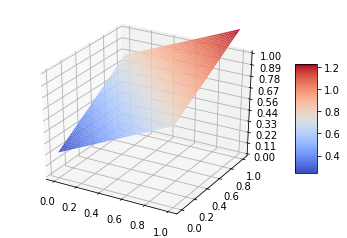

In [20]:
tf.reset_default_graph()

x_data = [[0.0, 0.0], [0.0, 1.0], [1.0, 0.0], [1.0, 1.0]]
y_data = [[0.0], [1.0], [1.0], [1.0]]

x = tf.placeholder(dtype=tf.float32, shape=(None, 2))
y_ = tf.placeholder(dtype=tf.float32, shape=(None, 1))

# 2 x 2 lattice with 1 output.
# lattice_param is [output_dim, 4] tensor.
lattice_sizes = [2, 2]
(y, lattice_param, _, regularization) = tfl.lattice_layer(
    x, lattice_sizes=[2, 2], output_dim=1, l2_torsion_reg=1.0)

# Sqaured loss
loss = tf.reduce_mean(tf.square(y - y_))
loss += regularization

# Minimize!
train_op = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(loss)

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
# Iterate 1000 times
for _ in range(1000):
    # Apply gradient.
    sess.run(train_op, feed_dict={x: x_data, y_: y_data})

# Fetching trained lattice parameter.
lattice_param_val = sess.run(lattice_param)
# Draw it!
# With heavy Torsion regularization, the model becomes a linear model.
lattice_surface(lattice_param_val[0])